### Logistic Regression

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import compose

In [2]:
# Load dataset
base_dir = "../datasets/"
orders_df = pd.read_csv(base_dir + "orders.csv")

# Convert timestamp to date time
orders_df["created_at"] = pd.to_datetime(orders_df["created_at"])

# Create date related features
# Year and month are left out, see
orders_df["day_of_week"] = orders_df["created_at"].dt.dayofweek
orders_df["month"] = orders_df["created_at"].dt.month
orders_df["time_of_day"] = orders_df["created_at"].dt.hour + orders_df["created_at"].dt.minute / 60
orders_df["day_of_month"] = orders_df["created_at"].dt.day 

In [3]:
# Filter outliers

filter_elevation = (orders_df["to_user_elevation"] < 600) 
filter_earnings = (orders_df["total_earning"] < 40000) & (orders_df["total_earning"] > 0)
filter_distance = orders_df["to_user_distance"] < 8

orders_df = orders_df[filter_elevation & filter_earnings & filter_distance]

In [4]:
orders_df.columns

Index(['order_id', 'store_id', 'to_user_distance', 'to_user_elevation',
       'total_earning', 'created_at', 'taken', 'day_of_week', 'month',
       'time_of_day', 'day_of_month'],
      dtype='object')

In [5]:
features = orders_df[["to_user_distance", "to_user_elevation", "total_earning", "day_of_week", "time_of_day", "day_of_month"]]
labels = orders_df["taken"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, labels, test_size = 0.25, stratify=labels, random_state=314)

In [6]:
# Verify selected features
X_train.columns

Index(['to_user_distance', 'to_user_elevation', 'total_earning', 'day_of_week',
       'time_of_day', 'day_of_month'],
      dtype='object')

In [7]:
# Verify strtification
y_test.describe()

count    36744.000000
mean         0.921212
std          0.269412
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: taken, dtype: float64

In [8]:
# First model using weight balancing
model = linear_model.LogisticRegression(random_state=314, max_iter=100, class_weight="balanced")
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=314)

In [9]:
# Get scores
print( "ROC-auc train", metrics.roc_auc_score(y_train, model.predict(X_train)) )
print( "ROC-auc test", metrics.roc_auc_score(y_test, model.predict(X_test)) )

ROC-auc train 0.5997661319714612
ROC-auc train 0.5918095406037512


<AxesSubplot:xlabel='x', ylabel='y'>

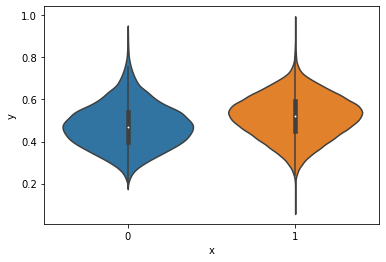

In [10]:
# Plot violin plot to have an idea of the class separations
probs_train = model.predict_proba(X_train)

plot_df = pd.DataFrame({"x": y_train, "y": probs_train[:, 1]})
sns.violinplot(data=plot_df, y="y", x="x")

not so well separated....

makeIs it perhaps better to scale the featues...it should not make much difference

In [11]:
# K fold cross validation performace of model with no scaling
model_1 = linear_model.LogisticRegression(random_state=314, max_iter=100, class_weight="balanced")
result = model_selection.cross_validate(model_1, X_train, y_train, cv=5, scoring="roc_auc", return_train_score=True)
print("Plain model score: ", result["test_score"])
print("mean test score: ", np.mean(result["test_score"]))
print("mean train score: ", np.mean(result["train_score"]))

# K fold cross validation performace of model with scaling
model_2 = pipeline.Pipeline( [("scaler", preprocessing.StandardScaler()), ("predictor", model_1)] )
result = model_selection.cross_validate(model_2, X_train, y_train, cv=5, scoring="roc_auc", return_train_score=True)
print("Plain model score: ", result["test_score"])
print("mean test score: ", np.mean(result["test_score"]))
print("mean train score: ", np.mean(result["train_score"]))


# K fold cross validation performace of model with one hot encoding of day of week
compose_scaler = compose.ColumnTransformer( [("scaler", preprocessing.StandardScaler(), ['to_user_distance', 'to_user_elevation', 'total_earning', 'time_of_day'])],
                                                        remainder="passthrough")

compose_encoder = compose.ColumnTransformer( [("encoder", preprocessing.OneHotEncoder(), [4, 5])],
                                             remainder="passthrough")

model_3 = pipeline.Pipeline( [  ("scaler", compose_scaler), 
                                ("encoder", compose_encoder), 
                                ("predictor", model_1)] )

result = model_selection.cross_validate(model_3, X_train, y_train, cv=5, scoring="roc_auc", return_train_score=True)
print("Plain model score: ", result["test_score"])
print("mean test score: ", np.mean(result["test_score"]))
print("mean train score: ", np.mean(result["train_score"]))


Plain model score:  [0.6209617  0.63420595 0.63721765 0.61942091 0.62792782]
mean test score:  0.6279468056183093
mean train score:  0.6290262332753433
Plain model score:  [0.62446693 0.63467073 0.63653134 0.62237285 0.62791895]
mean test score:  0.6291921590358154
mean train score:  0.6301451014114601
Plain model score:  [0.65967257 0.66200751 0.66152603 0.64604134 0.65692265]
mean test score:  0.6572340188078074
mean train score:  0.6601480778066949



Train and validation are pretty close...no overfitting

Scaling increments performance a bit, one hot encoding is better than encondig the day_of_week/month with a number

#### Add popular store info...

In [13]:
# In this cell we want to compute if a store is popular, in the sense that many orders are taken for that store
# We compute the probability of taken for the store ids
# This probability is only reliable if we have enough data for that particular store
# We define a store to be popular if:
#     (number_data_points(store_id) > th1) and (prob_taken(store_id) > th2
# We define a store to be un_popular if:
#     (number_data_points(store_id) > th1) and (prob_taken(store_id) < th3
# If a store is not popular or unpopular the it is undefined

aux = orders_df.copy()

# Add columns "is_taken" and "not_taken"
aux["is_taken"] = (aux["taken"] == 1) 
aux["not_taken"] = (aux["taken"] == 0)

# Group by store_id and sum the number of taken, is_taken and not_taken
aux = aux.groupby("store_id").agg("sum")[["taken", "is_taken", "not_taken"]]

# Total orders is just the sum of taken and not taken
aux["total_orders"] = (aux["is_taken"] + aux["not_taken"])

# The store rating is its propability of taken
aux["rating"] = aux["is_taken"] / aux["total_orders"] 
aux = aux.sort_values("rating", ascending=False)

# Create the popularity column
aux["popularity"] = 0

th1 = 50
th2 = 0.66
th3 = 0.33
filter_popular = (aux["total_orders"] > th1) & (aux["rating"] > th2)
filter_unpopular = (aux["total_orders"] > th1) & (aux["rating"] < th3)

aux.loc[filter_popular, "popularity"] = 1
aux.loc[filter_unpopular, "popularity"] = -1

# Get the popular stores
popular_store_ids = aux.loc[ aux["popularity"] == 1].index
popular_stores_ids = list(popular_store_ids)


In [14]:
X_train_popular = X_train.copy()
X_train_popular["store_id"] = orders_df.loc[X_train_popular.index, "store_id"]
X_train_popular["popular_store"] = X_train_popular.apply( lambda row: 1 if (row.store_id in popular_store_ids) else 0, axis=1 )
X_train_popular.drop(columns="store_id", inplace=True)

In [15]:
# K fold cross validation performace of model with one hot encoding of day of week
compose_scaler = compose.ColumnTransformer( [("scaler", preprocessing.StandardScaler(), ['to_user_distance', 'to_user_elevation', 'total_earning', 'time_of_day'])],
                                                        remainder="passthrough")

compose_encoder = compose.ColumnTransformer( [("encoder", preprocessing.OneHotEncoder(), [4, 5])],
                                             remainder="passthrough")

model_3 = pipeline.Pipeline( [  ("scaler", compose_scaler), 
                                ("encoder", compose_encoder), 
                                ("predictor", model_1)] )

result = model_selection.cross_validate(model_3, X_train_popular, y_train, cv=5, scoring="roc_auc", return_train_score=True)
print("Plain model score: ", result["test_score"])
print("mean test score: ", np.mean(result["test_score"]))
print("mean train score: ", np.mean(result["train_score"]))

Plain model score:  [0.66445396 0.66670873 0.66753874 0.65458922 0.66525971]
mean test score:  0.6637100720182904
mean train score:  0.666584167353309


No change adding popular stores ids...